In [2]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning

warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

import seaborn as sns
from diffSPH.util import evalArea
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from scipy import interpolate
from diffSPH.modules.neighborSearch import radiusCompactHashMap, periodicNeighborSearch
from diffSPH.util import scatter_sum
from diffSPH.kernels import *
from diffSPH.randomParticles import generatePeriodicRandomParticles

Cuda compiler: /home/winchenbach/anaconda3/envs/torch2


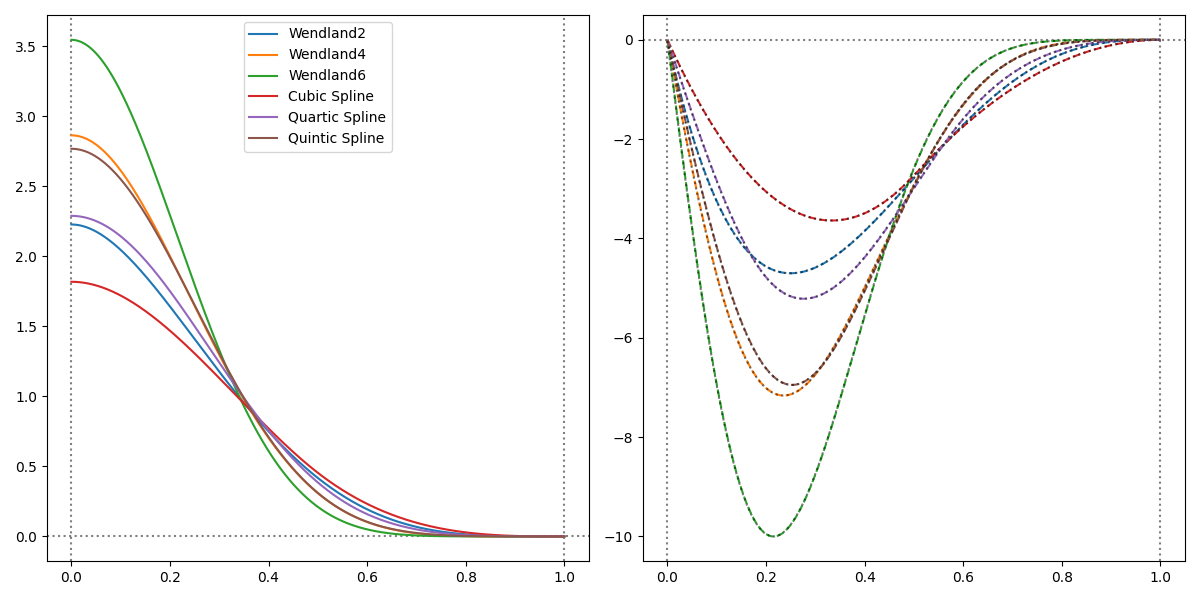

In [3]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

xx = torch.linspace(0, 1, 1024)
nx = xx / (xx + 1e-12)
dx = 1e-3

axis[0,0].axvline(0, ls = ':', c = 'black', alpha = 0.5)
axis[0,0].axvline(1, ls = ':', c = 'black', alpha = 0.5)
axis[0,0].axhline(0, ls = ':', c = 'black', alpha = 0.5)
axis[0,1].axvline(0, ls = ':', c = 'black', alpha = 0.5)
axis[0,1].axvline(1, ls = ':', c = 'black', alpha = 0.5)
axis[0,1].axhline(0, ls = ':', c = 'black', alpha = 0.5)

def plotKernel(fig, axis, xx, nx, dx, Kernel, i, label):
    fx = Kernel.kernel(xx, torch.ones_like(xx), 2)
    dfx = Kernel.kernelGradient(xx, nx[:,None], torch.ones_like(xx), 2)
    ndfx = (Kernel.kernel(xx + dx, torch.ones_like(xx), 2) - Kernel.kernel(xx, torch.ones_like(xx), 2)) / dx
    
    axis[0,0].plot(xx,fx, c = colors[i], label = label)
    axis[0,1].plot(xx,dfx[:,0], ls = '--', c = colors[i], label = label)
    axis[0,1].plot(xx,ndfx, ls = ':', c = 'black', alpha = 0.5)


plotKernel(fig, axis, xx, nx, dx, Wendland2, 0, 'Wendland2')
plotKernel(fig, axis, xx, nx, dx, Wendland4, 1, 'Wendland4')
plotKernel(fig, axis, xx, nx, dx, Wendland6, 2, 'Wendland6')
plotKernel(fig, axis, xx, nx, dx, CubicSpline, 3, 'Cubic Spline')
plotKernel(fig, axis, xx, nx, dx, QuarticSpline, 4, 'Quartic Spline')
plotKernel(fig, axis, xx, nx, dx, QuinticSpline, 5, 'Quintic Spline')

axis[0,0].legend()
fig.tight_layout()